In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
path = glob('../Automatic_Number_Plate_Recognition/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [3]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

filepath  xmin  xmax  ymin  ymax
0  ../Automatic_Number_Plate_Recognition/images\N...  1093  1396   645   727
1  ../Automatic_Number_Plate_Recognition/images\N...   134   301   312   350
2  ../Automatic_Number_Plate_Recognition/images\N...    31   139   128   161
3  ../Automatic_Number_Plate_Recognition/images\N...   164   316   216   243
4  ../Automatic_Number_Plate_Recognition/images\N...   813  1067   665   724

In [4]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../Automatic_Number_Plate_Recognition/images',filename_image)
    return filepath_image
getFilename(filename)

'../Automatic_Number_Plate_Recognition/images\\N1.jpeg'

In [5]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['../Automatic_Number_Plate_Recognition/images\\N1.jpeg',
 '../Automatic_Number_Plate_Recognition/images\\N100.jpeg',
 '../Automatic_Number_Plate_Recognition/images\\N101.jpeg',
 '../Automatic_Number_Plate_Recognition/images\\N102.jpeg',
 '../Automatic_Number_Plate_Recognition/images\\N103.jpeg',
 '../Automatic_Number_Plate_Recognition/images\\N104.jpeg',
 '../Automatic_Number_Plate_Recognition/images\\N105.jpeg',
 '../Automatic_Number_Plate_Recognition/images\\N106.jpeg',
 '../Automatic_Number_Plate_Recognition/images\\N107.jpeg',
 '../Automatic_Number_Plate_Recognition/images\\N108.jpeg']

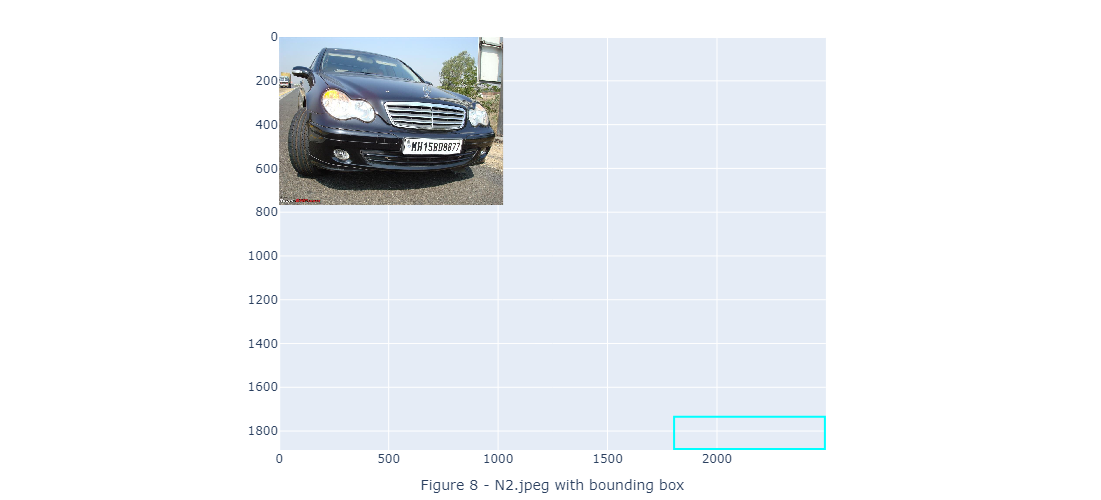

In [6]:
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

In [7]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [8]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [9]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [16]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'../Automatic_Number_Plate_Recognition/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  ../Automatic_Number_Plate_Recognition/images\N...  1093  1396   645   727   
1  ../Automatic_Number_Plate_Recognition/images\N...   134   301   312   350   
2  ../Automatic_Number_Plate_Recognition/images\N...    31   139   128   161   
3  ../Automatic_Number_Plate_Recognition/images\N...   164   316   216   243   
4  ../Automatic_Number_Plate_Recognition/images\N...   813  1067   665   724   

                                            filename  width  height  center_x  \
0  ../Automatic_Number_Plate_Recognition/images/N...   1920    1080  0.648177   
1  ../Automatic_Number_Plate_Recognition/images/N...    450     417  0.483333   
2  ../Automatic_Number_Plate_Recognition/images/N...    249     239  0.341365   
3  ../Automatic_Number_Plate_Recognition/images/N...    478     395  0.502092   
4  ../Automatic_Number_Plate_Recognition/images/N...   1800    1200  0.522222   

   center_y  bb_width  bb_height  
0  0.635185  0.157812   0.075926  
1  0.793765  0.371111   0.091127  
2  0.604603  0.433735   0.138075  
3  0.581013  0.317992   0.068354  
4  0.578750  0.141111   0.049167

In [17]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  ../Automatic_Number_Plate_Recognition/images\N...  1093  1396   645   727   
1  ../Automatic_Number_Plate_Recognition/images\N...   134   301   312   350   
2  ../Automatic_Number_Plate_Recognition/images\N...    31   139   128   161   
3  ../Automatic_Number_Plate_Recognition/images\N...   164   316   216   243   
4  ../Automatic_Number_Plate_Recognition/images\N...   813  1067   665   724   

                                            filename  width  height  center_x  \
0  ../Automatic_Number_Plate_Recognition/images/N...   1920    1080  0.648177   
1  ../Automatic_Number_Plate_Recognition/images/N...    450     417  0.483333   
2  ../Automatic_Number_Plate_Recognition/images/N...    249     239  0.341365   
3  ../Automatic_Number_Plate_Recognition/images/N...    478     395  0.502092   
4  ../Automatic_Number_Plate_Recognition/images/N...   1800    1200  0.522222   

   center_y  bb_width  bb_height  
0  0.635185  0.157812   0.075926  
1  0.793765  0.371111   0.091127  
2  0.604603  0.433735   0.138075  
3  0.581013  0.317992   0.068354  
4  0.578750  0.141111   0.049167

In [18]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

In [19]:
fname

'../input/number-plate-detection/images/N1.jpeg'

In [22]:
train_folder = './data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()